In [35]:
from config import CONFIG
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
%matplotlib notebook
import math
import numpy as np
import pandas as pd
import sys
import time

In [36]:
path = CONFIG['PATH']
start_date='2017-01-01'
end_date='2017-12-31'
dates=pd.date_range(start_date, end_date)
merged_candlesticks=pd.DataFrame(index=dates)

for pair in CONFIG['PAIRS']:
    candlesticks = pd.read_csv(path + "/data/"+ pair.replace('/','-') +"/candlesticks.csv", parse_dates=True, usecols=['date','close'], na_values=['nan'])
    candlesticks['date'] = pd.Series([dt.datetime.fromtimestamp(int(ts)).strftime('%Y-%m-%d')
                                     for ts in candlesticks['date']]).values
    candlesticks = candlesticks.set_index('date')
    candlesticks = candlesticks.rename(columns={'close':pair})
    merged_candlesticks=merged_candlesticks.join(candlesticks)
    merged_candlesticks.dropna()
print(merged_candlesticks.head(5)) 

             ETH/BTC   LTC/BTC   BTS/BTC  STEEM/BTC
2017-01-01  0.008220  0.004500  0.000004   0.000152
2017-01-02  0.009280  0.004427  0.000004   0.000151
2017-01-03  0.009745  0.004066  0.000004   0.000153
2017-01-04  0.010185  0.004227  0.000004   0.000156
2017-01-05  0.011272  0.004317  0.000004   0.000173


In [37]:
print(merged_candlesticks.loc['2017-01-01':'2017-12-31', ['BTS/BTC','STEEM/BTC']].head(5))

             BTS/BTC  STEEM/BTC
2017-01-01  0.000004   0.000152
2017-01-02  0.000004   0.000151
2017-01-03  0.000004   0.000153
2017-01-04  0.000004   0.000156
2017-01-05  0.000004   0.000173


<IPython.core.display.Javascript object>


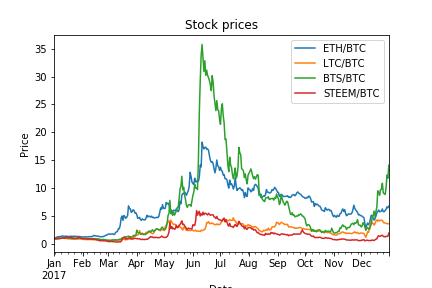

In [50]:
def plot_data(df, title="Stock prices"):
    ax = df.plot(title=title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()
    
def normalize_data(df):
    return df / df.iloc[0,:]

normalize_data(merged_candlesticks)
plot_data(merged_candlesticks)

In [5]:
window = 20
no_of_std = 2

rm_btc = pd.Series(candlesticks['close']).rolling(window=window).mean()
rstd_btc = pd.Series(candlesticks['close']).rolling(window=window).std()
candlesticks['Rolling Mean'] = rm_btc
candlesticks['Rolling Mean'].fillna(method='bfill', inplace=True)


candlesticks['Bollinger High'] = rm_btc + (rstd_btc * no_of_std)
candlesticks['Bollinger High'].fillna(method='bfill', inplace=True)

candlesticks['Bollinger Low'] = rm_btc - (rstd_btc * no_of_std)
candlesticks['Bollinger Low'].fillna(method='bfill', inplace=True)

x = candlesticks['date']
ax = candlesticks[['close','Rolling Mean', 'Bollinger High', 'Bollinger Low']].plot(x, title="BTC/ETC Bollinger Bands", label="BTC/ETC")

ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend(loc='upper left')

KeyError: 'close'